In [2]:
import numpy as np
import scipy.signal
import tensorstore as ts
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
import asyncio
from tqdm.asyncio import tqdm_asyncio
from mpl_toolkits.axes_grid1 import ImageGrid

## Load trigger data

In [3]:

def load_stimuli_and_ephys(file_handle, num_channels=10):
  try:
    data = np.fromfile(file_handle, dtype=np.float32)
  except io.UnsupportedOperation:
    data = np.frombuffer(file_handle.read(), dtype=np.float32)
  if data.size % num_channels:
    raise ValueError(f'Data does not fit in num_channels: {num_channels}')
  return data.reshape((-1, num_channels)).T

with open('/groups/saalfeld/saalfeldlab/zapbench-release/volumes/20240930/stimuli_raw/stimuli_and_ephys.10chFlt', 'rb') as f:
  stimuli_and_ephys = load_stimuli_and_ephys(f)

In [4]:
# ttls trace is acquired at 6 kHz.
ttls_freq_khz = 6.0

In [ ]:
ttls = stimuli_and_ephys[2]
ttls_high = scipy.signal.find_peaks(ttls, distance=500, height=3.55)[0]
ttls_low = scipy.signal.find_peaks(ttls, distance=50, height=1)[0]

# This logic from the zapbench notebook doesn't work. There are instances
# where you find low_peaks displaced from the high_peak by a small distance.
# this results in the `low_peaks` signal falsely reporting 73 frames per stack.
# See interval tree logic below.

# remove volume imaging start steps and only keep plane imaging steps
# low_peaks = np.array([l for l in ttls_low if l not in ttls_high])
# high_peaks = ttls_high

# if a low peak is within 5 time steps of a high peak we delete it.
tree = KDTree(np.expand_dims(ttls_low, 1))
inds = tree.query_radius(np.expand_dims(ttls_high, 1), r=5)
select = np.ones_like(ttls_low, dtype=bool)
for i in inds:
  for j in i:
    select[j] = False
low_peaks = ttls_low[select]
high_peaks = ttls_high

In [19]:
len(high_peaks)

7872

57 slices


Text(0, 0.5, 'ttls value')

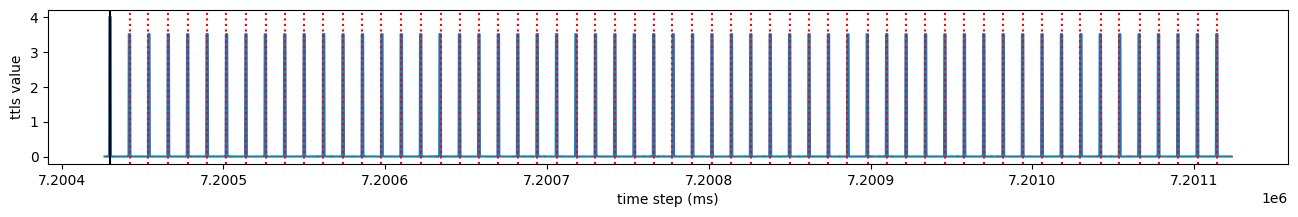

In [ ]:
# which time step to visualize. Valid = 0, ..., 7871
# Note that 7871 is a partial trace - only 57 low peaks. Others are complete
# and have the expected 72 steps.
index = 7871
imin = high_peaks[index] - 20
imax = high_peaks[index+1] + 20 if index + 1 < len(high_peaks) else len(ttls)


plt.figure(figsize=(16,2))
plt.plot(np.arange(imin, imax)/ttls_freq_khz, ttls[imin:imax])

jmin, jmax = np.searchsorted(low_peaks, [imin, imax])
print(jmax-jmin, "slices")
for x in low_peaks[jmin:jmax]:
  plt.axvline(x/ttls_freq_khz, color="r", ls="dotted")

for x in high_peaks[index:index+2]:
  plt.axvline(x/ttls_freq_khz, color="k")
plt.xlabel("time step (ms)")
plt.ylabel("ttls value")


In [ ]:
# assertions to check our understanding
# for whatever reason we only have data for t=0, ..., 7871
num_time_steps = 7872
zsteps = 72

# 72 low peaks between adjacent high peaks
assert (high_peaks[1:] > high_peaks[:-1]).all()
zstack_index = np.searchsorted(high_peaks, low_peaks) - 1
frames_per_zstack = np.bincount(zstack_index)
# 7871 zstacks have exactly 72 slices (as expected)
# But the last zstack has only 57 slices - maybe we stopped recording it?
frames_per_zstack, np.unique(frames_per_zstack, return_counts=True),


In [ ]:
# we have complete info for these
# we will just average and assume the same pattern for what we don't observe
ts_per_slice = low_peaks[:(num_time_steps-1)*zsteps].reshape((-1, zsteps))
print(ts_per_slice.shape)


In [ ]:
# impute missing data by fitting the observed frames

xvs = np.arange(ts_per_slice.shape[0])
fit = np.polyfit(xvs, ts_per_slice[:, 0], 1)
unk_xvs = np.arange(ts_per_slice.shape[0], 7879)
pred_first = np.expand_dims((fit[0]*unk_xvs + fit[1]), 1)
offset_remaining = np.expand_dims((ts_per_slice - ts_per_slice[:, :1]).mean(axis=0), 0)
pred_ts_per_slice_remaining = (pred_first + offset_remaining).astype(np.int64)

timestamps_ms = np.concatenate([ts_per_slice, pred_ts_per_slice_remaining], axis=0).astype(np.float32)
# set origin to t=0
timestamps_ms -= timestamps_ms[0, 0]
# change units to ms
timestamps_ms /= ttls_freq_khz
# round
timestamps_ms = timestamps_ms.astype(np.int32)
print(timestamps_ms.shape)

In [ ]:
# Pull data from google storage since the raw data takes a while to download
gs_uri = "gs://zapbench-release/volumes/20240930"

ds = ts.open({
    'open': True,
    'driver': 'zarr3',
    'kvstore': f'{gs_uri}/traces'
}).result()
# Check that we have a time stamp for each neuronal trace
assert ds.shape[0] == timestamps_ms.shape[0]

In [ ]:
# Load segmentation
ds = ts.open({
    'open': True,
    'driver': 'zarr3',
    'kvstore': f'{gs_uri}/segmentation'
}).result()
segmentation = ds.read().result()

In [ ]:
# process segmentation to build a map between voxels and cell id's

xi, yi, zi = np.where(segmentation > 0)
# get to zero based indexing
cell_id_flat = segmentation[xi, yi, zi].astype(np.uint64)
cell_id_flat -= 1

cell_id_uniq, px_per_cell = np.unique(cell_id_flat, return_counts=True)
num_cells = cell_id_uniq.shape[0]
# cell_id_uniq = 0, 1, 2, ..., N-1
zs_order = np.lexsort((zi, cell_id_flat))
xi = xi[zs_order]
yi = yi[zs_order]
zi = zi[zs_order]
cell_id_flat = cell_id_flat[zs_order]

# Let's make a uint64 key of cellid, z.
# we should assert that cell id's are themselves sorted first.
sort_key = (cell_id_flat << 32).astype(np.uint64) + zi.astype(np.uint64)
assert (sort_key[1:] >= sort_key[:-1]).all()
_, first_index = np.unique(sort_key, return_index=True)

cell_ids = cell_id_flat[first_index].astype(np.int32)
z_per_cell = zi[first_index].astype(np.int32)

px_per_cell_per_z = np.zeros_like(first_index, dtype=np.int32)
px_per_cell_per_z[:-1] = np.diff(first_index)
px_per_cell_per_z[-1] = sort_key.shape[0] - first_index[-1]
assert cell_ids.shape == z_per_cell.shape == px_per_cell_per_z.shape

num_cellz = cell_ids.shape[0]
# each row = cell id C, z slice Z, containing P pixels
print(
  cell_ids[:10].tolist(),
  z_per_cell[:10].tolist(),
  px_per_cell_per_z[:10].tolist()
)
# cell_ids = [0, 0, 0, 1, 1, 1, 2, 2, 2, 2],
# ^ which cell does each piece belong to?

# z_per_cell = [13, 14, 15, 16, 17, 18, 5, 6, 7, 8],
# ^ which z slice is it?

# px_per_cell_per_z = [26, 62, 33, 9, 83, 27, 7, 100, 110, 88])
# ^ how many XY pixels in each piece?

## Plot Ca activity per cell split by z

In [16]:
# this is the df/f data
raw = ts.open({
    'open': True,
    'driver': 'zarr3',
    'kvstore': 'gs://zapbench-release/volumes/20240930/df_over_f_xyz_chunked/s0'
}).result()


In [ ]:
ds = ts.open({
    'open': True,
    'driver': 'zarr3',
    'kvstore': 'gs://zapbench-release/volumes/20240930/traces'
}).result()
traces = ds.read().result()

cell_id=64913


Text(0.5, 1.0, 'cell_id=64913')

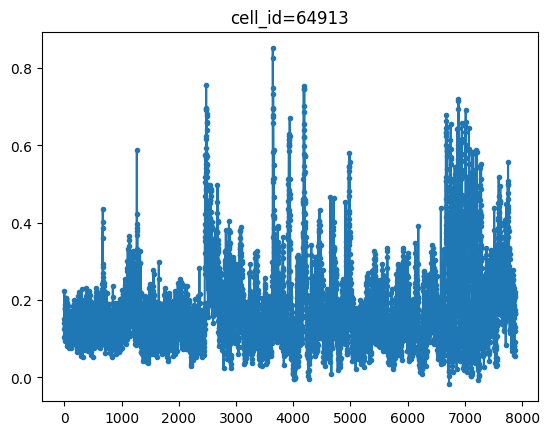

In [18]:
# Pick a cell to plot
cell_id = 64913
# cell_id = np.random.randint(0, 71721)

print(f"{cell_id=}")
i, j, k = np.where(segmentation == cell_id+1)
activity = np.array(traces[:, cell_id])
plt.plot(activity, marker=".")
plt.title(f"{cell_id=}")

In [20]:
tpeak = np.argmax(activity)
print(tpeak)
time_window = 20
tlow = max(tpeak-time_window, 0)
thigh = min(tpeak+time_window, raw.shape[-1]-1)

imin, imax = max(0, i.min()-1), i.max()+1
jmin, jmax = max(0, j.min()-1), j.max()+1
kmin, kmax = k.min(), k.max()+1
print(kmax-kmin, "zslices")
vol = np.array(raw[imin:imax, jmin:jmax, kmin:kmax, tlow:thigh])
mask = (segmentation[imin:imax, jmin:jmax, kmin:kmax] == cell_id+1).astype(np.uint8)

3643
2 zslices


Text(0.5, 0.98, 'cell_id=64913')

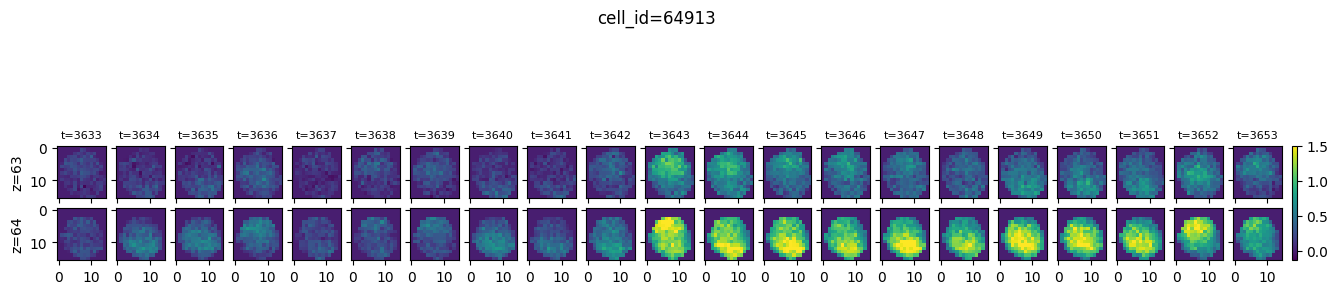

In [23]:
fig=plt.figure(figsize=(16, 4))
w = 10
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(vol.shape[2], 2*w+1),
                 axes_pad=0.1,
                 cbar_mode="single"
                 )
ax = grid.axes_row
vmin = vol.min()
vmax = vol.max()
for z in range(vol.shape[2]):
  for wi in range(2*w+1):
    im = ax[z][wi].imshow(vol[:, :, z, tpeak-tlow-w+wi]
                          *mask[:, :, z],
                           vmin=vmin, vmax=vmax)
    ax[0][wi].set_title(f"t={tpeak-w+wi}", fontsize=8)
  ax[z][0].set_ylabel(f"z={kmin+z}")
grid.cbar_axes[0].colorbar(im)
plt.suptitle(f"{cell_id=}")

Text(0.5, 0.98, 'cell_id=64913')

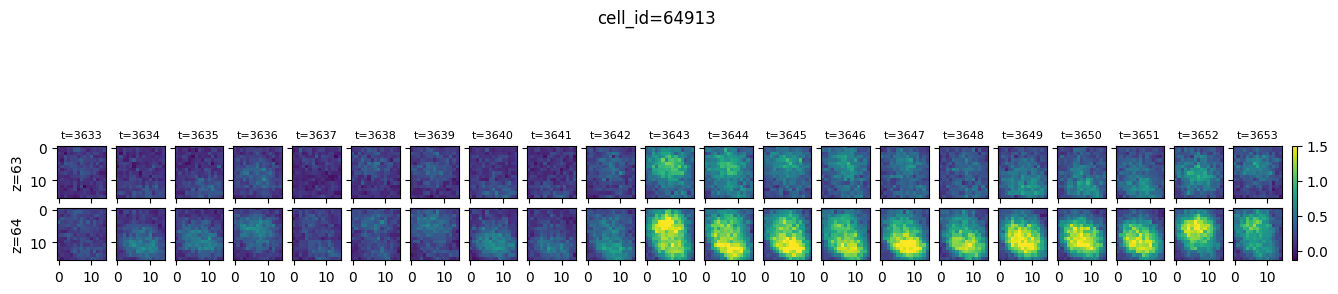

In [25]:
fig=plt.figure(figsize=(16, 4))
w = 10
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(vol.shape[2], 2*w+1),
                 axes_pad=0.1,
                 cbar_mode="single"
                 )
ax = grid.axes_row
vmin = vol.min()
vmax = vol.max()
for z in range(vol.shape[2]):
  for wi in range(2*w+1):
    im = ax[z][wi].imshow(vol[:, :, z, tpeak-tlow-w+wi],
                           vmin=vmin, vmax=vmax)
    ax[0][wi].set_title(f"t={tpeak-w+wi}", fontsize=8)
  ax[z][0].set_ylabel(f"z={kmin+z}")
grid.cbar_axes[0].colorbar(im)
plt.suptitle(f"{cell_id=}")

Text(0.5, 0, 'time steps around peak')

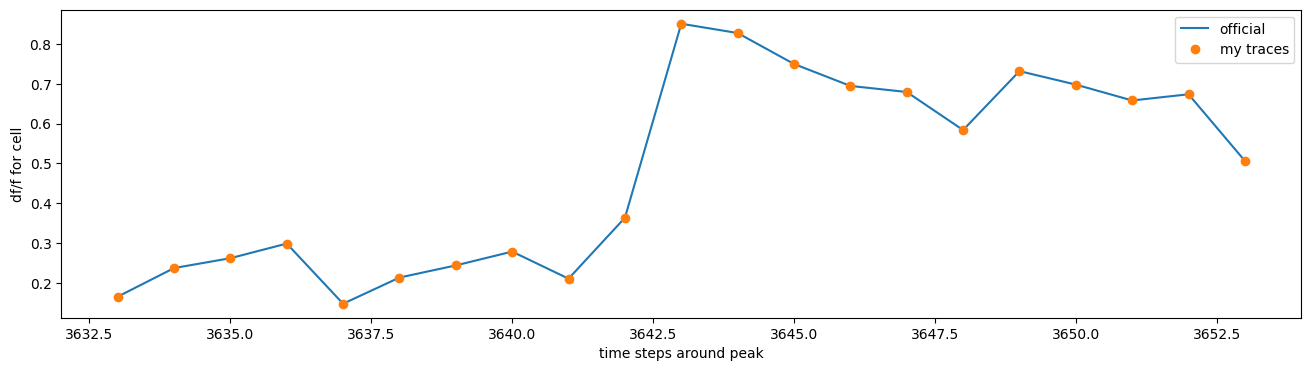

In [28]:
avg = np.array([[vol[:, :, z, tpeak-tlow-w+wi][mask[:, :, z].astype(bool)].mean() for wi in range(2*w+1)] for z in range(vol.shape[2])])
vol_avg = np.array([[vol[:, :, z, tpeak-tlow-w+wi][mask[:, :, z].astype(bool)].sum() for wi in range(2*w+1)] for z in range(vol.shape[2])]).sum(0) / mask.sum()
plt.figure(figsize=(16,4))
plt.plot([tpeak-w+wi for wi in range(2*w+1)], activity[tpeak-w:tpeak+w+1], label="official")
plt.plot([tpeak-w+wi for wi in range(2*w+1)], vol_avg, ls="", marker="o", label="my traces")
plt.legend()
plt.ylabel("df/f for cell")
plt.xlabel("time steps around peak")

## Reprocess data - takes many many hours

Do not rerun since it will attempt to rewrite the data (and fail) </br>
Data available at `/groups/saalfeld/saalfeldlab/zapbench-processed/20251007`

In [ ]:
output_path = "/groups/saalfeld/saalfeldlab/zapbench-processed/20251007"
output_uri = f"file://{output_path}"

In [ ]:
with open(f"{output_path}/per_cell_z_data.npz", "wb") as out:
  np.savez_compressed(
      out,
      cell_id=cell_ids,
      z_cell=z_per_cell,
      num_pxs=px_per_cell_per_z,
      allow_pickle=False,
  )

with open(f"{output_path}/timestamps_ms.npz", "wb") as out:
  np.savez_compressed(
      out,
      timestamps_ms=timestamps_ms,
      allow_pickle=False,
  )

In [ ]:
num_parallel = 4

In [ ]:

async def process_time_point(i, vol):
    """Process a single time slice."""

    vals = vol[xi, yi, zi]
    ixs = np.repeat(np.arange(cell_ids.shape[0]), px_per_cell_per_z)
    slice_avg = np.bincount(ixs, weights=vals).astype(np.float32)
    slice_avg /= px_per_cell_per_z
    return i, slice_avg

async def process_all(output_uri):

    # dF/F data per voxel (chunked spatially for more efficient processing)
    src = await ts.open({
        'open': True,
        'driver': 'zarr3',
        'kvstore': f"{gs_uri}/df_over_f_xyz_chunked/s0",
        "context": {"cache_pool": {"total_bytes_limit": 1024*1024*128}}
    })
    shape = src.domain.shape

    dst_activity = await ts.open({
        "driver": "zarr3",
        "kvstore": f"{output_uri}/cell_z_activity.zarr",
        "dtype": "float32",
        "create": True,
        "delete_existing": False,
    },
    shape=(shape[3], num_cellz),
    )

    dst_timestamps = await ts.open({
        "driver": "zarr3",
        "kvstore": f"{output_uri}/cell_z_time_ms.zarr",
        "dtype": "int32",
        "create": True,
        "delete_existing": False,
    },
    shape=(shape[3], num_cellz),
    )

    semaphore = asyncio.Semaphore(num_parallel)

    async def load_process_write(i):
        async with semaphore:
            chunk = await src[:, :, :, i].read()
            _, processed = await process_time_point(i, chunk)
            await asyncio.gather(
                dst_activity[i, :].write(processed),
                dst_timestamps[i, :].write(timestamps_ms[i, z_per_cell])
            )
            return i

    # Launch all chunk tasks concurrently
    tasks = [asyncio.create_task(load_process_write(i)) for i in range(shape[3])]
    await tqdm_asyncio.gather(*tasks, desc="Processing + Writing chunks", total=len(tasks))

    print("✅ All chunks processed and written to:", output_uri)


await process_all(output_uri)
